In [10]:
from data import create_spiral
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from models import SpiralModelTripleLayer

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
X, y = create_spiral(N=500, gamma=0.2)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
epochs = 250
NUM_OF_MODELS = 2000
triple_layer_models =[]
for model in range(NUM_OF_MODELS):
    model_1 = SpiralModelTripleLayer().to(device)
    optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-1, weight_decay=1e-3)
    for epoch in range(epochs):
        model_1.train()
        y_logits = model_1(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y_train)
        acc = acc_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model_1.eval()
        with torch.inference_mode():
            test_logits = model_1(X_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = acc_fn(test_pred, y_test)

        if (model + 1) % 50 == 0:
            if (epoch + 1) % 100 == 0:
                print(
                    f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}"
                )
    triple_layer_models.append(model_1.state_dict())

Epoch: 99 | Loss: 0.04 Acc: 1.00 | Test loss: 0.04 Test acc: 0.99
Epoch: 199 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 99 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00
Epoch: 199 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00
Epoch: 99 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 199 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00
Epoch: 99 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 199 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 99 | Loss: 0.04 Acc: 1.00 | Test loss: 0.04 Test acc: 0.99
Epoch: 199 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 99 | Loss: 0.05 Acc: 0.99 | Test loss: 0.05 Test acc: 0.99
Epoch: 199 | Loss: 0.04 Acc: 1.00 | Test loss: 0.04 Test acc: 0.99
Epoch: 99 | Loss: 0.04 Acc: 0.99 | Test loss: 0.05 Test acc: 0.99
Epoch: 199 | Loss: 0.04 Acc: 0.99 | Test loss: 0.03 Test acc: 0.99
Epoch: 99 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epo

In [19]:
import pickle

with open("3_layer_models.pickle", "wb") as f:
    pickle.dump(triple_layer_models, f)
    print("Saved trained models")

Saved trained models


In [20]:
def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

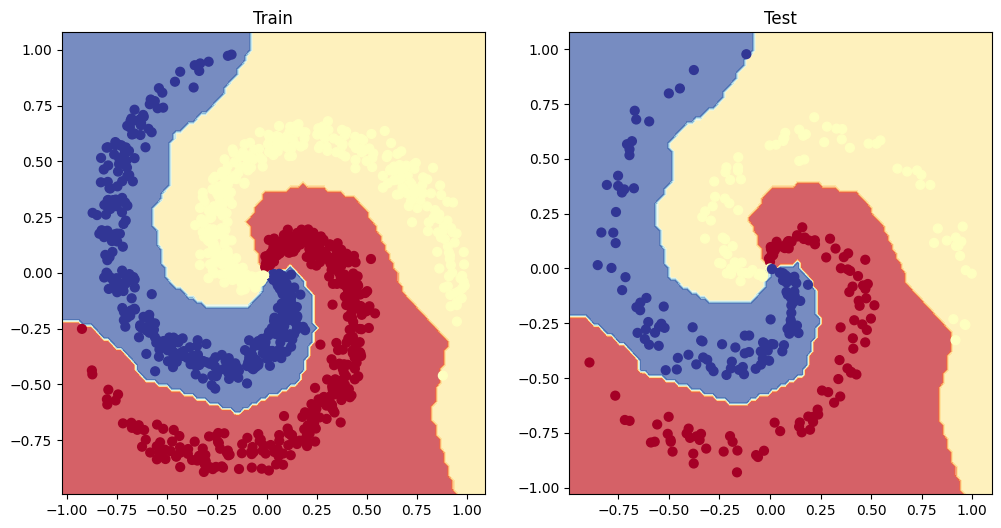

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [22]:
state_dict = triple_layer_models[0]
model_test = SpiralModelTripleLayer().to(device)
model_test.load_state_dict(state_dict)
model_test.eval()
with torch.inference_mode():
    test_logits = model_test(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc = acc_fn(test_pred, y_test)
print(test_acc.item())

0.9933333396911621
